In [1]:
%pip install -q torch torchvision numpy nibabel tqdm scikit-learn scikit-image scipy matplotlib pandas opencv-python requests albumentations seaborn tensorboard


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import tarfile
import requests
from pathlib import Path
from datetime import datetime
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import confusion_matrix

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


2026-02-15 16:35:52.139552: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-15 16:35:52.149828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771173352.163931    2718 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771173352.168403    2718 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771173352.179303    2718 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

PyTorch version: 2.7.0
CUDA available: True


In [2]:
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
DATASET_NAME = "Task06_Lung"
RAW_DATA_DIR = DATA_DIR / DATASET_NAME
IMAGES_TR_DIR = RAW_DATA_DIR / "imagesTr"
LABELS_TR_DIR = RAW_DATA_DIR / "labelsTr"
DOWNLOAD_URL = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar"
DATASET_TAR_FILE = DATA_DIR / "Task06_Lung.tar"
CHECKPOINT_DIR = PROJECT_ROOT / "checkpoints"
LOG_DIR = PROJECT_ROOT / "logs"
VISUALIZATION_DIR = PROJECT_ROOT / "visualizations"

BATCH_SIZE = 4
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
NUM_WORKERS = 0
TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT = 0.8, 0.1, 0.1
IN_CHANNELS, NUM_CLASSES, BASE_CHANNEL_COUNT = 1, 2, 32
MAX_SHAPE = (256, 256, 256)
EARLY_STOPPING_PATIENCE = 15
DICE_LOSS_WEIGHT, CE_LOSS_WEIGHT = 0.5, 0.5

for d in [DATA_DIR, CHECKPOINT_DIR, LOG_DIR, VISUALIZATION_DIR]:
    d.mkdir(parents=True, exist_ok=True)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    USE_AMP = True
else:
    DEVICE = torch.device("cpu")
    USE_AMP = False
print(f"Using device: {DEVICE} (AMP: {USE_AMP})")


Using device: cuda (AMP: True)


In [3]:
def download_file(url, dest_path):
    dest_path = Path(dest_path)
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(dest_path, 'wb') as f, tqdm(desc=dest_path.name, total=total_size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
        for data in response.iter_content(chunk_size=1024):
            f.write(data)
            pbar.update(len(data))
    print("Download complete.")

if RAW_DATA_DIR.exists():
    print("Data already exists.")
else:
    if not DATASET_TAR_FILE.exists():
        download_file(DOWNLOAD_URL, str(DATASET_TAR_FILE))
    else:
        print("Tar file already exists.")
    print("Extracting...")
    with tarfile.open(DATASET_TAR_FILE, 'r') as tar:
        tar.extractall(path=DATA_DIR)
    print("Extraction complete.")

image_files = sorted([p for p in IMAGES_TR_DIR.glob("*.nii.gz") if not p.name.startswith("._")])
label_files = sorted([p for p in LABELS_TR_DIR.glob("*.nii.gz") if not p.name.startswith("._")])
image_files = [str(p) for p in image_files]
label_files = [str(p) for p in label_files]
print(f"Found {len(image_files)} image files, {len(label_files)} label files")


Task06_Lung.tar: 100%|██████████| 8.53G/8.53G [05:15<00:00, 29.0MB/s] 


Download complete.
Extracting...
Extraction complete.
Found 63 image files, 63 label files


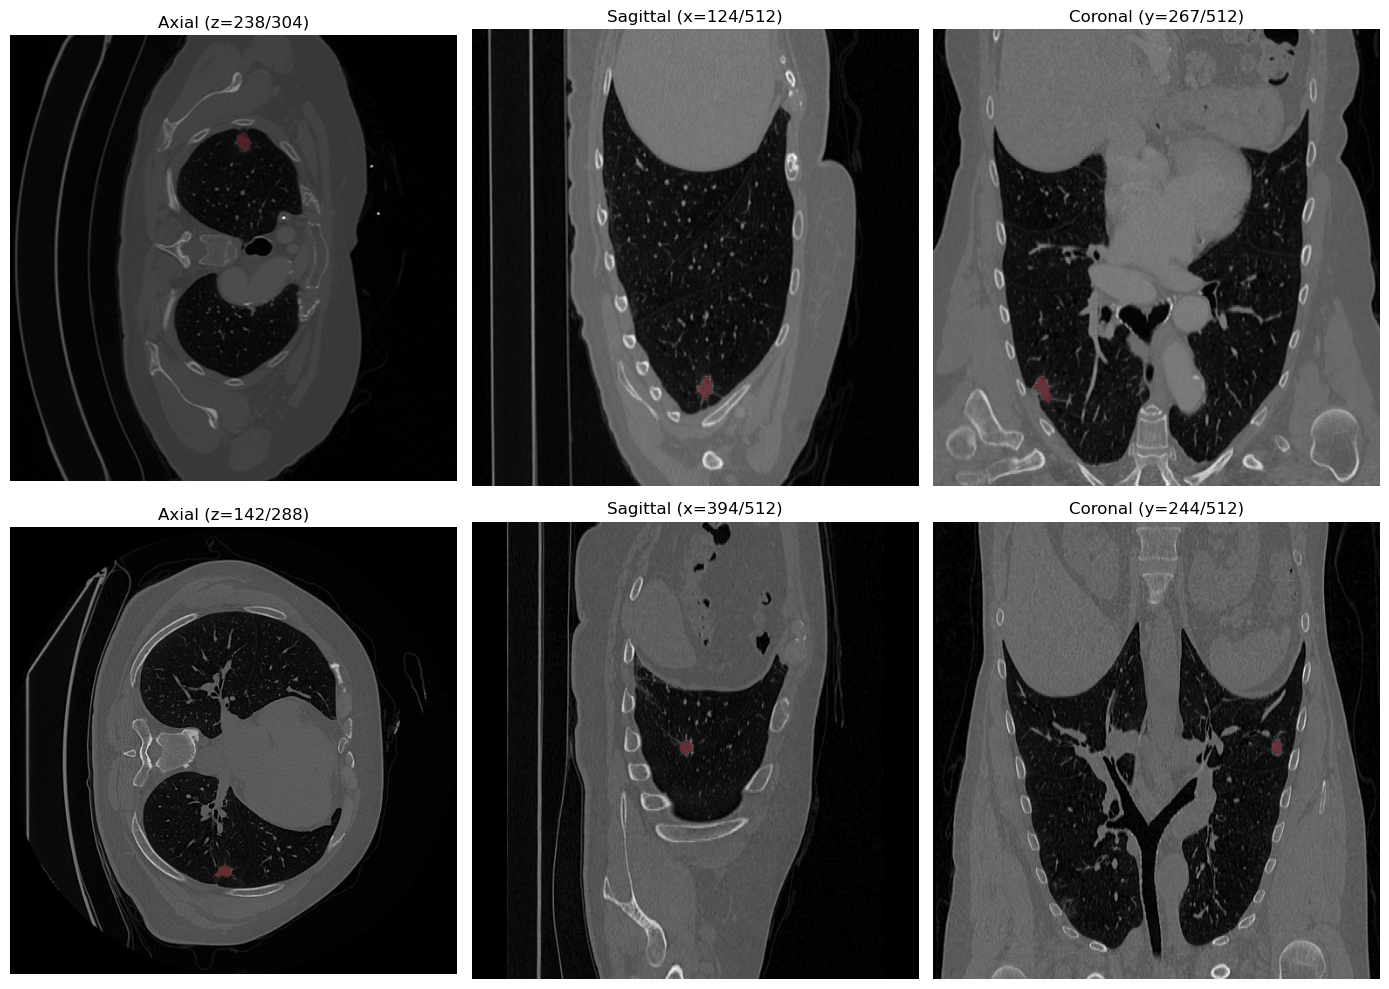

In [4]:
def norm(x):
    x = np.asarray(x, dtype=float)
    lo, hi = np.nanmin(x), np.nanmax(x)
    return (x - lo) / (hi - lo + 1e-8)

n_samples = min(2, len(image_files))
fig, axes = plt.subplots(n_samples, 3, figsize=(14, 5 * n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_samples):
    img_vol = nib.load(image_files[i]).get_fdata()
    mask_bin = (nib.load(label_files[i]).get_fdata() > 0.5).astype(np.float32)
    H, W, D = img_vol.shape
    coords = np.argwhere(mask_bin > 0.5)
    if len(coords) > 0:
        mx, my, mz = coords.mean(axis=0).astype(int)
    else:
        mz, mx, my = D // 2, H // 2, W // 2

    axes[i, 0].imshow(norm(img_vol[:, :, mz]), cmap="gray")
    axes[i, 0].imshow(np.ma.masked_where(mask_bin[:, :, mz] < 0.5, mask_bin[:, :, mz]), cmap="Reds", alpha=0.5, vmin=0, vmax=1)
    axes[i, 0].set_title(f"Axial (z={mz}/{D})")
    axes[i, 0].axis("off")

    sag = np.transpose(img_vol[mx, :, :], (1, 0))
    sag_m = np.transpose(mask_bin[mx, :, :], (1, 0))
    axes[i, 1].imshow(norm(sag), cmap="gray", aspect="auto")
    axes[i, 1].imshow(np.ma.masked_where(sag_m < 0.5, sag_m), cmap="Reds", alpha=0.5, vmin=0, vmax=1, aspect="auto")
    axes[i, 1].set_title(f"Sagittal (x={mx}/{H})")
    axes[i, 1].axis("off")

    cor = np.transpose(img_vol[:, my, :], (1, 0))
    cor_m = np.transpose(mask_bin[:, my, :], (1, 0))
    axes[i, 2].imshow(norm(cor), cmap="gray", aspect="auto")
    axes[i, 2].imshow(np.ma.masked_where(cor_m < 0.5, cor_m), cmap="Reds", alpha=0.5, vmin=0, vmax=1, aspect="auto")
    axes[i, 2].set_title(f"Coronal (y={my}/{W})")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


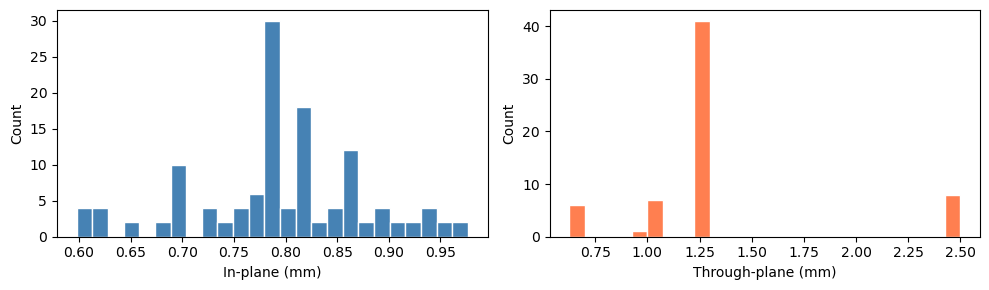

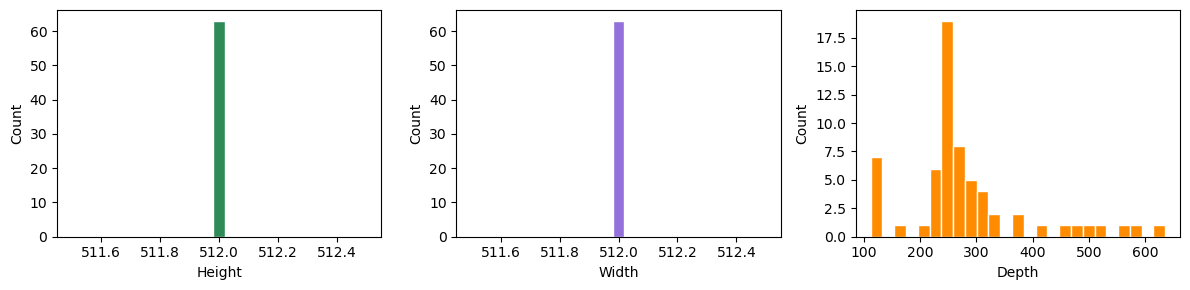

In [5]:
from nibabel.affines import voxel_sizes

in_plane, through_plane = [], []
H_vals, W_vals, D_vals = [], [], []

for p in image_files:
    nii = nib.load(p)
    s = voxel_sizes(nii.affine)
    in_plane.extend([float(s[0]), float(s[1])])
    through_plane.append(float(s[2]))
    sh = nii.shape
    H_vals.append(sh[0])
    W_vals.append(sh[1])
    D_vals.append(sh[2])

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(in_plane, bins=25, color="steelblue", edgecolor="white")
axes[0].set_xlabel("In-plane (mm)")
axes[0].set_ylabel("Count")
axes[1].hist(through_plane, bins=25, color="coral", edgecolor="white")
axes[1].set_xlabel("Through-plane (mm)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(H_vals, bins=25, color="seagreen", edgecolor="white")
axes[0].set_xlabel("Height")
axes[0].set_ylabel("Count")
axes[1].hist(W_vals, bins=25, color="mediumpurple", edgecolor="white")
axes[1].set_xlabel("Width")
axes[1].set_ylabel("Count")
axes[2].hist(D_vals, bins=25, color="darkorange", edgecolor="white")
axes[2].set_xlabel("Depth")
axes[2].set_ylabel("Count")
plt.tight_layout()
plt.show()

In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom

train_img, temp_img, train_lbl, temp_lbl = train_test_split(
    image_files, label_files, test_size=VAL_SPLIT + TEST_SPLIT, random_state=42
)
val_img, test_img, val_lbl, test_lbl = train_test_split(
    temp_img, temp_lbl, test_size=TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT), random_state=42
)

max_H, max_W, max_D = 0, 0, 0
for p in train_img:
    h, w, d = nib.load(p).shape[:3]
    max_H, max_W, max_D = max(max_H, h), max(max_W, w), max(max_D, d)
target_shape = (min(max_H, MAX_SHAPE[0]), min(max_W, MAX_SHAPE[1]), min(max_D, MAX_SHAPE[2]))

def resize_to_shape(x, shape, order=1):
    factors = (shape[0] / x.shape[0], shape[1] / x.shape[1], shape[2] / x.shape[2])
    return zoom(x, factors, order=order)

def pad_or_crop(x, target_shape):
    H, W, D = x.shape[:3]
    tH, tW, tD = target_shape
    if H >= tH:
        start_h = (H - tH) // 2
        x = x[start_h:start_h + tH, :, :]
    if W >= tW:
        start_w = (W - tW) // 2
        x = x[:, start_w:start_w + tW, :]
    if D >= tD:
        start_d = (D - tD) // 2
        x = x[:, :, start_d:start_d + tD]
    H, W, D = x.shape[:3]
    need_h, need_w, need_d = tH - H, tW - W, tD - D
    if need_h > 0 or need_w > 0 or need_d > 0:
        x = np.pad(x, ((0, need_h), (0, need_w), (0, need_d)), mode="constant", constant_values=0)
    return x

class Dataset3D(Dataset):
    def __init__(self, image_paths, label_paths, target_shape):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.target_shape = target_shape

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = nib.load(self.image_paths[idx]).get_fdata()
        msk = nib.load(self.label_paths[idx]).get_fdata()
        if img.shape[0] > self.target_shape[0] or img.shape[1] > self.target_shape[1] or img.shape[2] > self.target_shape[2]:
            img = resize_to_shape(img, self.target_shape, order=1)
            msk = resize_to_shape(msk, self.target_shape, order=0)
        else:
            img = pad_or_crop(img, self.target_shape)
            msk = pad_or_crop(msk, self.target_shape)
        msk = (msk > 0.5).astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = np.expand_dims(img.astype(np.float32), axis=0)
        msk = np.expand_dims(msk.astype(np.float32), axis=0)
        return torch.from_numpy(img), torch.from_numpy(msk)
print(f"Padded/cropped to: {target_shape[0]} x {target_shape[1]} x {target_shape[2]}")
train_ds = Dataset3D(train_img, train_lbl, target_shape)
val_ds = Dataset3D(val_img, val_lbl, target_shape)
test_ds = Dataset3D(test_img, test_lbl, target_shape)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

Padded/cropped to: 256 x 256 x 256


In [7]:
class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        return x * self.psi(F.relu(g1 + x1))

class ConvBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p=0.0):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_ch)
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.res = nn.Conv3d(in_ch, out_ch, 1, bias=False) if in_ch != out_ch else None
        self.dropout = nn.Dropout3d(dropout_p) if dropout_p > 0 else None

    def forward(self, x):
        r = self.res(x) if self.res is not None else x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)) + r)
        return self.dropout(out) if self.dropout is not None else out

class DownBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p=0.0):
        super().__init__()
        self.pool = nn.MaxPool3d(2, 2)
        self.conv = ConvBlock3D(in_ch, out_ch, dropout_p)

    def forward(self, x):
        return self.conv(self.pool(x))

class UpBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p=0.0):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_ch, in_ch, kernel_size=2, stride=2)
        self.attn = AttentionBlock3D(F_g=in_ch, F_l=out_ch, F_int=out_ch // 2)
        self.conv = ConvBlock3D(in_ch + out_ch, out_ch, dropout_p)

    def forward(self, x, bridge):
        x = self.up(x)
        d, h, w = bridge.shape[2], bridge.shape[3], bridge.shape[4]
        if x.shape[2] != d or x.shape[3] != h or x.shape[4] != w:
            x = F.interpolate(x, size=(d, h, w), mode="trilinear", align_corners=True)
        bridge = self.attn(g=x, x=bridge)
        x = torch.cat([bridge, x], dim=1)
        return self.conv(x)

class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=1, num_classes=2, base_channels=32, dropout_p=0.1):
        super().__init__()
        c = base_channels
        self.enc1 = ConvBlock3D(in_channels, c, 0)
        self.enc2 = DownBlock3D(c, c * 2, dropout_p)
        self.enc3 = DownBlock3D(c * 2, c * 4, dropout_p)
        self.enc4 = DownBlock3D(c * 4, c * 8, dropout_p)
        self.enc5 = DownBlock3D(c * 8, c * 16, dropout_p)
        self.dec4 = UpBlock3D(c * 16, c * 8, dropout_p)
        self.dec3 = UpBlock3D(c * 8, c * 4, dropout_p)
        self.dec2 = UpBlock3D(c * 4, c * 2, dropout_p)
        self.dec1 = UpBlock3D(c * 2, c, dropout_p)
        self.final = nn.Conv3d(c, num_classes, 1)

    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # (B, 1, D, H, W)
        enc1 = self.enc1(x)  # (B, 32, D, H, W)
        enc2 = self.enc2(enc1)  # (B, 64, D/2, H/2, W/2)
        enc3 = self.enc3(enc2)  # (B, 128, D/4, H/4, W/4)
        enc4 = self.enc4(enc3)  # (B, 256, D/8, H/8, W/8)
        enc5 = self.enc5(enc4)  # (B, 512, D/16, H/16, W/16)
        dec4 = self.dec4(enc5, enc4)  # (B, 256, D/8, H/8, W/8)
        dec3 = self.dec3(dec4, enc3)  # (B, 128, D/4, H/4, W/4)
        dec2 = self.dec2(dec3, enc2)  # (B, 64, D/2, H/2, W/2)
        dec1 = self.dec1(dec2, enc1)  # (B, 32, D, H, W)
        return self.final(dec1)  # (B, num_classes, D, H, W)


In [8]:
dummy = torch.randn(1, 1, *target_shape)
model = AttentionUNet3D(in_channels=1, num_classes=2, base_channels=32, dropout_p=0.0)
model.eval()
with torch.no_grad():
    x = dummy.permute(0, 1, 4, 2, 3)
    enc1 = model.enc1(x)
    enc2 = model.enc2(enc1)
    enc3 = model.enc3(enc2)
    enc4 = model.enc4(enc3)
    enc5 = model.enc5(enc4)
    dec4 = model.dec4(enc5, enc4)
    dec3 = model.dec3(dec4, enc3)
    dec2 = model.dec2(dec3, enc2)
    dec1 = model.dec1(dec2, enc1)
    out = model.final(dec1)
expected = [
    ("input (after permute)", (1, 1, target_shape[2], target_shape[0], target_shape[1])),
    ("enc1", (1, 32, target_shape[2], target_shape[0], target_shape[1])),
    ("enc2", (1, 64, target_shape[2]//2, target_shape[0]//2, target_shape[1]//2)),
    ("enc3", (1, 128, target_shape[2]//4, target_shape[0]//4, target_shape[1]//4)),
    ("enc4", (1, 256, target_shape[2]//8, target_shape[0]//8, target_shape[1]//8)),
    ("enc5", (1, 512, target_shape[2]//16, target_shape[0]//16, target_shape[1]//16)),
    ("dec4", (1, 256, target_shape[2]//8, target_shape[0]//8, target_shape[1]//8)),
    ("dec3", (1, 128, target_shape[2]//4, target_shape[0]//4, target_shape[1]//4)),
    ("dec2", (1, 64, target_shape[2]//2, target_shape[0]//2, target_shape[1]//2)),
    ("dec1", (1, 32, target_shape[2], target_shape[0], target_shape[1])),
    ("output", (1, 2, target_shape[2], target_shape[0], target_shape[1])),
]
tensors = [x, enc1, enc2, enc3, enc4, enc5, dec4, dec3, dec2, dec1, out]
for (name, exp_shape), t in zip(expected, tensors):
    actual = tuple(t.shape)
    ok = actual == exp_shape
    print(f"{name}: expected {exp_shape}, actual {actual}  {'OK' if ok else 'MISMATCH'}")

input (after permute): expected (1, 1, 256, 256, 256), actual (1, 1, 256, 256, 256)  OK
enc1: expected (1, 32, 256, 256, 256), actual (1, 32, 256, 256, 256)  OK
enc2: expected (1, 64, 128, 128, 128), actual (1, 64, 128, 128, 128)  OK
enc3: expected (1, 128, 64, 64, 64), actual (1, 128, 64, 64, 64)  OK
enc4: expected (1, 256, 32, 32, 32), actual (1, 256, 32, 32, 32)  OK
enc5: expected (1, 512, 16, 16, 16), actual (1, 512, 16, 16, 16)  OK
dec4: expected (1, 256, 32, 32, 32), actual (1, 256, 32, 32, 32)  OK
dec3: expected (1, 128, 64, 64, 64), actual (1, 128, 64, 64, 64)  OK
dec2: expected (1, 64, 128, 128, 128), actual (1, 64, 128, 128, 128)  OK
dec1: expected (1, 32, 256, 256, 256), actual (1, 32, 256, 256, 256)  OK
output: expected (1, 2, 256, 256, 256), actual (1, 2, 256, 256, 256)  OK


In [12]:
class DiceCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, ce_weight=0.5, smooth=1e-5):
        super().__init__()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.smooth = smooth
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, target):
        target_ce = target.squeeze(1).long()
        probs = F.softmax(logits, dim=1)
        dice_loss = 0.0
        for c in range(logits.shape[1]):
            p = probs[:, c]
            t = (target_ce == c).float()
            inter = (p * t).sum()
            union = p.sum() + t.sum()
            dice_loss += 1.0 - (2.0 * inter + self.smooth) / (union + self.smooth)
        dice_loss = dice_loss / logits.shape[1]
        ce_loss = self.ce(logits, target_ce)
        return self.dice_weight * dice_loss + self.ce_weight * ce_loss

def dice_score(logits, target, smooth=1e-6):
    pred = logits.argmax(dim=1).float()
    t = target.squeeze(1).float()
    inter = (pred * t).sum()
    return (2.0 * inter + smooth) / (pred.sum() + t.sum() + smooth)

model = AttentionUNet3D(in_channels=1, num_classes=2, base_channels=32, dropout_p=0.1).to(DEVICE)
criterion = DiceCELoss(dice_weight=0.5, ce_weight=0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)

start_epoch = 1
best_val_dice = 0.0
last_ckpt_path = CHECKPOINT_DIR / "last_3dunet.pth"
if last_ckpt_path.exists():
    ckpt = torch.load(last_ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    scheduler.load_state_dict(ckpt["scheduler_state_dict"])
    start_epoch = ckpt["epoch"] + 1
    best_val_dice = ckpt.get("val_dice", 0.0)

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for img, msk in tqdm(train_loader, desc=f"Train Epoch {epoch}", leave=False):
        img, msk = img.to(DEVICE), msk.to(DEVICE)
        msk = msk.permute(0, 1, 4, 2, 3)
        optimizer.zero_grad()
        logits = model(img)
        loss = criterion(logits, msk)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for img, msk in tqdm(val_loader, desc=f"Val Epoch {epoch}", leave=False):
            img, msk = img.to(DEVICE), msk.to(DEVICE)
            msk = msk.permute(0, 1, 4, 2, 3)
            logits = model(img)
            val_loss += criterion(logits, msk).item()
            val_dice += dice_score(logits, msk).item()
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    scheduler.step(val_dice)

    ckpt = {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "scheduler_state_dict": scheduler.state_dict(), "val_dice": val_dice, "val_loss": val_loss}
    torch.save(ckpt, CHECKPOINT_DIR / "last_3dunet.pth")
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(ckpt, CHECKPOINT_DIR / "best_3dunet.pth")
    print(f"Epoch {epoch}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  val_dice={val_dice:.4f}  best_dice={best_val_dice:.4f}")

Epoch 1  train_loss=0.3365  val_loss=0.2664  val_dice=0.0000  best_dice=0.0000


Epoch 2  train_loss=0.2517  val_loss=0.2545  val_dice=0.0000  best_dice=0.0000


Epoch 3  train_loss=0.2517  val_loss=0.2538  val_dice=0.0000  best_dice=0.0000


Epoch 4  train_loss=0.2497  val_loss=0.2487  val_dice=0.0000  best_dice=0.0000


Epoch 5  train_loss=0.2465  val_loss=0.2470  val_dice=0.0082  best_dice=0.0082


Epoch 6  train_loss=0.2447  val_loss=0.2537  val_dice=0.0011  best_dice=0.0082


Epoch 7  train_loss=0.2537  val_loss=0.2574  val_dice=0.0000  best_dice=0.0082


Epoch 8  train_loss=0.2426  val_loss=0.2519  val_dice=0.0019  best_dice=0.0082


Epoch 9  train_loss=0.2183  val_loss=0.2637  val_dice=0.0010  best_dice=0.0082


Epoch 10  train_loss=0.2148  val_loss=0.2760  val_dice=0.0000  best_dice=0.0082


Epoch 11  train_loss=0.2524  val_loss=0.2559  val_dice=0.0000  best_dice=0.0082


Epoch 12  train_loss=0.2517  val_loss=0.2544  val_dice=0.0000  best_dice=0.0082


Epoch 13  train_loss=0.2510  val_loss=0.2553  val_dice=0.0000  best_dice=0.0082


Epoch 14  train_loss=0.2422  val_loss=0.2485  val_dice=0.0390  best_dice=0.0390


Epoch 15  train_loss=0.1892  val_loss=0.2470  val_dice=0.0483  best_dice=0.0483


Epoch 16  train_loss=0.1717  val_loss=0.2523  val_dice=0.0389  best_dice=0.0483


Epoch 17  train_loss=0.1623  val_loss=0.2308  val_dice=0.1182  best_dice=0.1182


Epoch 18  train_loss=0.1497  val_loss=0.2342  val_dice=0.1116  best_dice=0.1182


Epoch 19  train_loss=0.1423  val_loss=0.2401  val_dice=0.0783  best_dice=0.1182


Epoch 20  train_loss=0.1372  val_loss=0.2386  val_dice=0.0947  best_dice=0.1182


Epoch 21  train_loss=0.1438  val_loss=0.2378  val_dice=0.0958  best_dice=0.1182


Epoch 22  train_loss=0.1330  val_loss=0.2227  val_dice=0.1480  best_dice=0.1480


Epoch 23  train_loss=0.1268  val_loss=0.2150  val_dice=0.1811  best_dice=0.1811


Epoch 24  train_loss=0.1211  val_loss=0.2230  val_dice=0.1475  best_dice=0.1811


Epoch 25  train_loss=0.1197  val_loss=0.2331  val_dice=0.1251  best_dice=0.1811


Epoch 26  train_loss=0.1259  val_loss=0.2333  val_dice=0.1008  best_dice=0.1811


Epoch 27  train_loss=0.1181  val_loss=0.2337  val_dice=0.1079  best_dice=0.1811


Epoch 28  train_loss=0.1170  val_loss=0.2374  val_dice=0.0973  best_dice=0.1811


Epoch 29  train_loss=0.1128  val_loss=0.2126  val_dice=0.1876  best_dice=0.1876


Epoch 30  train_loss=0.1084  val_loss=0.2232  val_dice=0.1528  best_dice=0.1876


Epoch 31  train_loss=0.1036  val_loss=0.2203  val_dice=0.1569  best_dice=0.1876


Epoch 32  train_loss=0.1087  val_loss=0.2211  val_dice=0.1570  best_dice=0.1876


Epoch 33  train_loss=0.1068  val_loss=0.2375  val_dice=0.0957  best_dice=0.1876


Epoch 34  train_loss=0.1085  val_loss=0.2173  val_dice=0.1771  best_dice=0.1876


Epoch 35  train_loss=0.1067  val_loss=0.2197  val_dice=0.1587  best_dice=0.1876


Epoch 36  train_loss=0.0989  val_loss=0.2187  val_dice=0.1630  best_dice=0.1876


Epoch 37  train_loss=0.0916  val_loss=0.2173  val_dice=0.1654  best_dice=0.1876


Epoch 38  train_loss=0.0940  val_loss=0.2330  val_dice=0.1061  best_dice=0.1876


Epoch 39  train_loss=0.0935  val_loss=0.2153  val_dice=0.1764  best_dice=0.1876


Epoch 40  train_loss=0.0923  val_loss=0.2184  val_dice=0.1622  best_dice=0.1876


Epoch 41  train_loss=0.0913  val_loss=0.2300  val_dice=0.1178  best_dice=0.1876


Epoch 42  train_loss=0.0897  val_loss=0.2178  val_dice=0.1661  best_dice=0.1876


Epoch 43  train_loss=0.0865  val_loss=0.2240  val_dice=0.1403  best_dice=0.1876


Epoch 44  train_loss=0.0868  val_loss=0.2192  val_dice=0.1583  best_dice=0.1876


Epoch 45  train_loss=0.0854  val_loss=0.2213  val_dice=0.1482  best_dice=0.1876


Epoch 46  train_loss=0.0860  val_loss=0.2211  val_dice=0.1513  best_dice=0.1876


Epoch 47  train_loss=0.0838  val_loss=0.2179  val_dice=0.1617  best_dice=0.1876


Epoch 48  train_loss=0.0833  val_loss=0.2227  val_dice=0.1407  best_dice=0.1876


Epoch 49  train_loss=0.0826  val_loss=0.2140  val_dice=0.1748  best_dice=0.1876


Epoch 50  train_loss=0.0802  val_loss=0.2202  val_dice=0.1520  best_dice=0.1876


Epoch 51  train_loss=0.0807  val_loss=0.2222  val_dice=0.1400  best_dice=0.1876


Epoch 52  train_loss=0.0802  val_loss=0.2236  val_dice=0.1375  best_dice=0.1876


Epoch 53  train_loss=0.0803  val_loss=0.2233  val_dice=0.1381  best_dice=0.1876


Epoch 54  train_loss=0.0795  val_loss=0.2233  val_dice=0.1366  best_dice=0.1876


Epoch 55  train_loss=0.0799  val_loss=0.2201  val_dice=0.1544  best_dice=0.1876


Epoch 56  train_loss=0.0784  val_loss=0.2284  val_dice=0.1188  best_dice=0.1876


Epoch 57  train_loss=0.0801  val_loss=0.2247  val_dice=0.1339  best_dice=0.1876


Epoch 58  train_loss=0.0796  val_loss=0.2248  val_dice=0.1313  best_dice=0.1876


Epoch 59  train_loss=0.0779  val_loss=0.2216  val_dice=0.1445  best_dice=0.1876


Epoch 60  train_loss=0.0778  val_loss=0.2218  val_dice=0.1436  best_dice=0.1876


Epoch 61  train_loss=0.0786  val_loss=0.2245  val_dice=0.1328  best_dice=0.1876


Epoch 62  train_loss=0.0773  val_loss=0.2229  val_dice=0.1388  best_dice=0.1876


Epoch 63  train_loss=0.0759  val_loss=0.2210  val_dice=0.1444  best_dice=0.1876


Epoch 64  train_loss=0.0770  val_loss=0.2225  val_dice=0.1407  best_dice=0.1876


Epoch 65  train_loss=0.0773  val_loss=0.2220  val_dice=0.1446  best_dice=0.1876


Epoch 66  train_loss=0.0758  val_loss=0.2247  val_dice=0.1336  best_dice=0.1876


Epoch 67  train_loss=0.0753  val_loss=0.2273  val_dice=0.1231  best_dice=0.1876


Epoch 68  train_loss=0.0770  val_loss=0.2209  val_dice=0.1474  best_dice=0.1876


Epoch 69  train_loss=0.0783  val_loss=0.2213  val_dice=0.1477  best_dice=0.1876


Epoch 70  train_loss=0.0759  val_loss=0.2245  val_dice=0.1338  best_dice=0.1876


Epoch 71  train_loss=0.0764  val_loss=0.2227  val_dice=0.1426  best_dice=0.1876


Epoch 72  train_loss=0.0755  val_loss=0.2269  val_dice=0.1241  best_dice=0.1876


Epoch 73  train_loss=0.0769  val_loss=0.2285  val_dice=0.1180  best_dice=0.1876


Epoch 74  train_loss=0.0745  val_loss=0.2279  val_dice=0.1192  best_dice=0.1876


Epoch 75  train_loss=0.0759  val_loss=0.2251  val_dice=0.1311  best_dice=0.1876


Epoch 76  train_loss=0.0768  val_loss=0.2248  val_dice=0.1326  best_dice=0.1876


Epoch 77  train_loss=0.0769  val_loss=0.2241  val_dice=0.1375  best_dice=0.1876


Epoch 78  train_loss=0.0750  val_loss=0.2226  val_dice=0.1432  best_dice=0.1876


Epoch 79  train_loss=0.0757  val_loss=0.2252  val_dice=0.1313  best_dice=0.1876


Epoch 80  train_loss=0.0759  val_loss=0.2263  val_dice=0.1252  best_dice=0.1876


Epoch 81  train_loss=0.0758  val_loss=0.2240  val_dice=0.1385  best_dice=0.1876


Epoch 82  train_loss=0.0776  val_loss=0.2239  val_dice=0.1377  best_dice=0.1876


Epoch 83  train_loss=0.0760  val_loss=0.2255  val_dice=0.1280  best_dice=0.1876


Epoch 84  train_loss=0.0753  val_loss=0.2259  val_dice=0.1280  best_dice=0.1876


Epoch 85  train_loss=0.0766  val_loss=0.2254  val_dice=0.1319  best_dice=0.1876


Epoch 86  train_loss=0.0757  val_loss=0.2257  val_dice=0.1295  best_dice=0.1876


Epoch 87  train_loss=0.0759  val_loss=0.2243  val_dice=0.1348  best_dice=0.1876


Epoch 88  train_loss=0.0767  val_loss=0.2263  val_dice=0.1282  best_dice=0.1876


Epoch 89  train_loss=0.0747  val_loss=0.2242  val_dice=0.1341  best_dice=0.1876


Epoch 90  train_loss=0.0759  val_loss=0.2256  val_dice=0.1298  best_dice=0.1876


Epoch 91  train_loss=0.0747  val_loss=0.2255  val_dice=0.1262  best_dice=0.1876


Epoch 92  train_loss=0.0757  val_loss=0.2231  val_dice=0.1397  best_dice=0.1876


Epoch 93  train_loss=0.0773  val_loss=0.2284  val_dice=0.1173  best_dice=0.1876


Epoch 94  train_loss=0.0762  val_loss=0.2244  val_dice=0.1344  best_dice=0.1876


Epoch 95  train_loss=0.0751  val_loss=0.2225  val_dice=0.1439  best_dice=0.1876


Epoch 96  train_loss=0.0760  val_loss=0.2266  val_dice=0.1266  best_dice=0.1876


Epoch 97  train_loss=0.0744  val_loss=0.2257  val_dice=0.1294  best_dice=0.1876


Epoch 98  train_loss=0.0757  val_loss=0.2228  val_dice=0.1404  best_dice=0.1876


Epoch 99  train_loss=0.0750  val_loss=0.2248  val_dice=0.1337  best_dice=0.1876


Epoch 100  train_loss=0.0744  val_loss=0.2246  val_dice=0.1342  best_dice=0.1876


In [13]:
model = AttentionUNet3D(in_channels=1, num_classes=2, base_channels=32, dropout_p=0.1).to(DEVICE)
ckpt = torch.load(CHECKPOINT_DIR / "best_3dunet.pth", map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
criterion = DiceCELoss(dice_weight=0.5, ce_weight=0.5).to(DEVICE)
test_loss = 0.0
test_dice = 0.0
with torch.no_grad():
    for img, msk in tqdm(test_loader, desc="Test"):
        img, msk = img.to(DEVICE), msk.to(DEVICE)
        msk = msk.permute(0, 1, 4, 2, 3)
        logits = model(img)
        test_loss += criterion(logits, msk).item()
        test_dice += dice_score(logits, msk).item()
test_loss /= len(test_loader)
test_dice /= len(test_loader)
print(f"Test loss: {test_loss:.4f}  Test Dice: {test_dice:.4f}")

Test: 100%|██████████| 7/7 [00:34<00:00,  4.96s/it]

Test loss: 0.1364  Test Dice: 0.4651


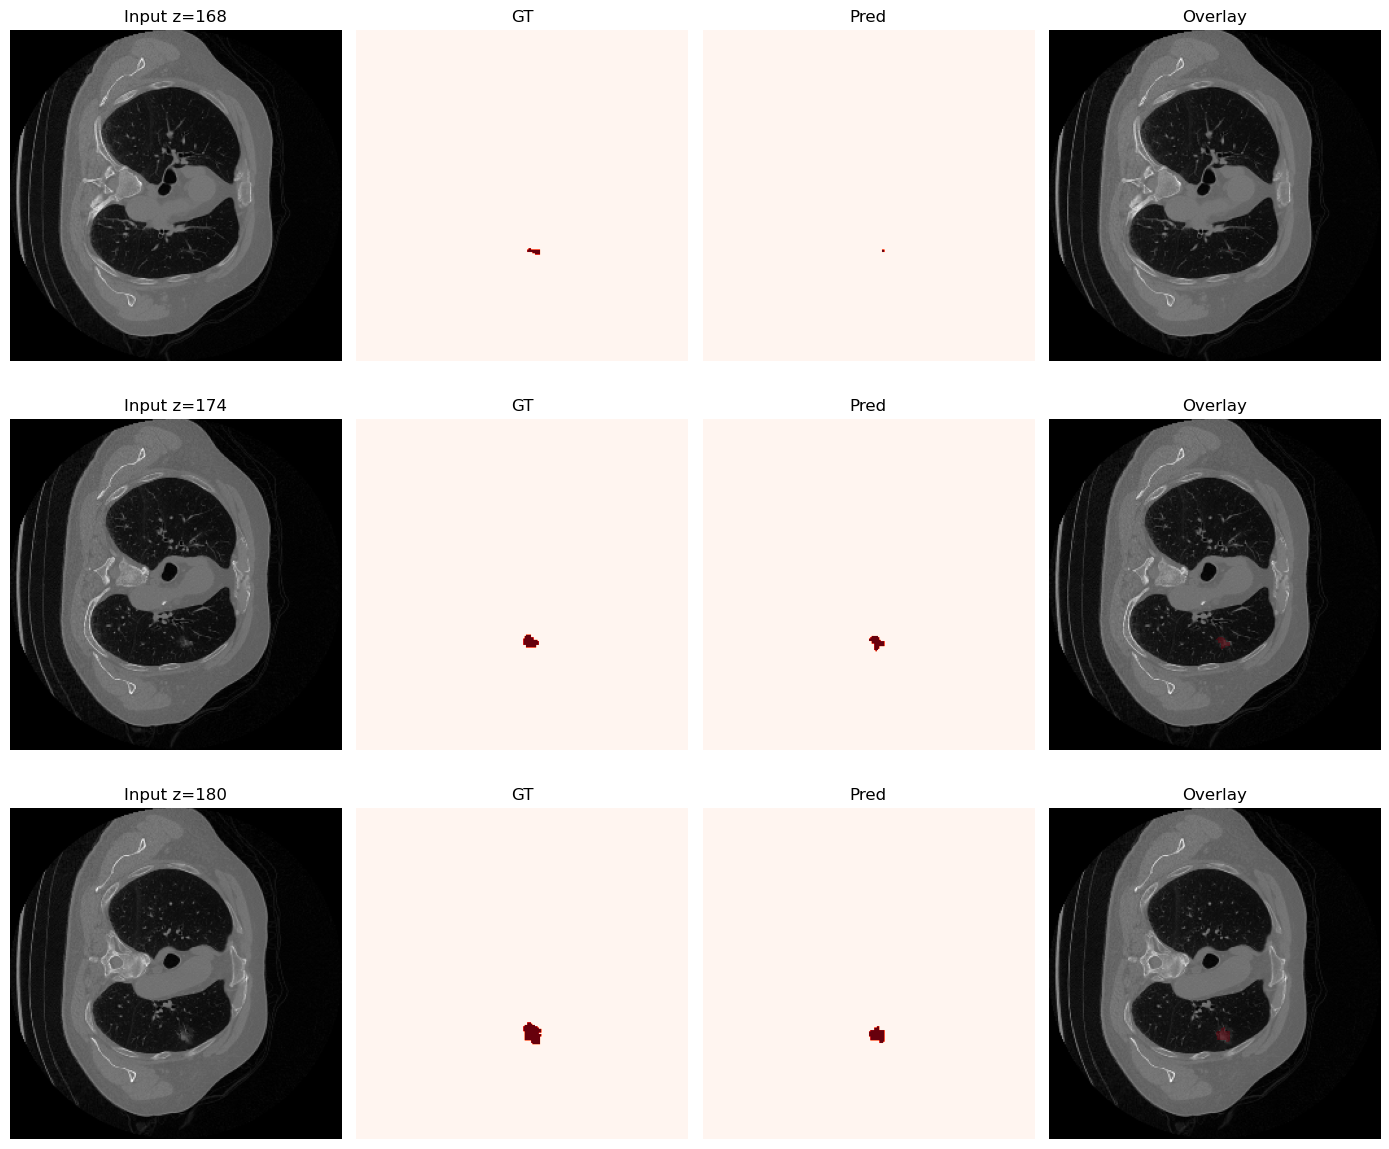

In [16]:
model.eval()
test_iter = iter(test_loader)
img, msk = next(test_iter)
while msk.sum() == 0:
    img, msk = next(test_iter)
img, msk = img.to(DEVICE), msk.to(DEVICE)
with torch.no_grad():
    logits = model(img)
pred = (logits.argmax(1).float().cpu().numpy()[0])
img_np = img.cpu().numpy()[0, 0]
msk_np = msk.cpu().numpy()[0, 0]
D = img_np.shape[2]
z_has_gt = np.where(np.sum(msk_np, axis=(0, 1)) > 0)[0]
if len(z_has_gt) >= 3:
    slices = [z_has_gt[len(z_has_gt) // 4], z_has_gt[len(z_has_gt) // 2], z_has_gt[3 * len(z_has_gt) // 4]]
else:
    slices = list(z_has_gt) if len(z_has_gt) > 0 else [D // 4, D // 2, 3 * D // 4]
fig, axes = plt.subplots(len(slices), 4, figsize=(14, 4 * len(slices)))
for i, z in enumerate(slices):
    axes[i, 0].imshow(img_np[:, :, z], cmap="gray")
    axes[i, 0].set_title(f"Input z={z}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(msk_np[:, :, z], cmap="Reds", vmin=0, vmax=1)
    axes[i, 1].set_title("GT")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(pred[z], cmap="Reds", vmin=0, vmax=1)
    axes[i, 2].set_title("Pred")
    axes[i, 2].axis("off")
    axes[i, 3].imshow(img_np[:, :, z], cmap="gray")
    axes[i, 3].imshow(np.ma.masked_where(pred[z] < 0.5, pred[z]), cmap="Reds", alpha=0.5, vmin=0, vmax=1)
    axes[i, 3].set_title("Overlay")
    axes[i, 3].axis("off")
plt.tight_layout()
plt.show()